In [1]:
## Figure 2 - Simulation of unwrapping error correction with bridging
## Figure S3 - Simulation process for a unwrapped interferogram
%matplotlib inline
import os
import time
import numpy as np
import random
from matplotlib import pyplot as plt
from skimage import morphology as morph
from pysar.simulation.plot import *
from pysar.simulation import simulation as sim, fractal
from pysar.objects import ifgramStack
from pysar.objects.conncomp import connectComponent
from pysar.utils import readfile, plot as pp, writefile, utils as ut

work_dir = os.path.expandvars('$PNOTE/sim_bridging')

# configure
shape = (300, 300) # size in (length, width) in pixel number
length, width = shape
ref_x, ref_y = int(0.9*width), int(0.2*length)
work_dir = os.path.join(work_dir, '300unzen')

#shape = (100, 100) # size in (length, width) in pixel number
#length, width = shape
#ref_x, ref_y = int(0.95*width), int(0.95*length)
#work_dir = os.path.join(work_dir, '100square')

os.chdir(work_dir)
print('Go to directory: '+work_dir)

# ref attributes
ref_dir = os.path.expanduser('~/insarlab/Galapagos/GalapagosSenDT128/PYSAR')
ref_file = os.path.join(ref_dir, 'timeseries.h5')
atr = readfile.read_attribute(ref_file)
L = int(atr['ALOOKS']) * int(atr['RLOOKS'])
range2phase = -4. * np.pi / float(atr['WAVELENGTH'])
resolution = ut.range_ground_resolution(atr)
print('spatial resolution: {:.1f} m'.format(resolution))
print('number of looks:', L)

# update atr
atr['LENGTH'] = length
atr['WIDTH'] = width
atr['REF_Y'] = ref_y
atr['REF_X'] = ref_x

# output file
sim_int_file = os.path.join(work_dir, 'sim.int')
sim_cor_file = os.path.join(work_dir, 'sim.cor')
sim_unw_file = os.path.join(work_dir, 'sim.unw')
snf_unw_file = os.path.join(work_dir, 'snf.unw')
bdg_unw_file = os.path.join(work_dir, 'bdg_snf.unw')
cc_file = snf_unw_file+'.conncomp'

Go to directory: /Users/yunjunz/development/python/2019_RSE_PYSAR/sim_bridging/300unzen
spatial resolution: 62.1 m
number of looks: 75


In [2]:
# utilities functions
from skimage import draw, transform as trans

def simulate_conn_comp(shape, ref_file=None, n=5):
    if ref_file:
        mask = readfile.read(ref_file, box=(0,200,3000,2700))[0]
        mask = trans.resize(mask, shape, mode='reflect', anti_aliasing=False)
        mask = mask == 1.0
    else:
        mask = np.ones(shape)
        # generate decorrelated boundaries
        rr, cc = draw.bezier_curve(int(0.0 *length),int(0.65*width), int(0.50*length),int(0.50*width), int(0.80*length),int(1.00*width),weight=2,shape=shape); mask[rr,cc] = 0
        rr, cc = draw.bezier_curve(int(0.40*length),int(0.0 *width), int(0.20*length),int(0.30*width), int(0.35*length),int(0.57*width),weight=1,shape=shape); mask[rr,cc] = 0
        rr, cc = draw.bezier_curve(int(0.50*length),int(0.62*width), int(0.50*length),int(0.80*width), int(0.25*length),int(1.00*width),weight=1,shape=shape); mask[rr,cc] = 0
        rr, cc = draw.circle(r=int(0.46*length), c=int(0.6*width), radius=int(0.20*length), shape=shape); mask[rr,cc] = 0
        # expand the boundaries
        for i in range(n):
            mask = morph.erosion(mask)
    return mask

def write_ifgram(sim_unw, sim_cor):
    print('write to file', sim_int_file)
    sim_int = np.zeros(sim_unw.shape, np.complex64)
    sim_int = np.cos(ut.wrap(sim_unw)) + 1j * np.sin(ut.wrap(sim_unw))
    sim_int.tofile(sim_int_file)
    print('write to file', sim_cor_file)
    sim_cor.tofile(sim_cor_file)
    print('write to file', sim_unw_file)
    writefile.write(sim_unw, sim_unw_file, atr)
    return

def plot_ifgram_simulation(defo, trop, ramp, decor, sim_unw):
    labels = ['defo', 'tropo', 'ramp', 'decor', 'total']
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=[10, 2], sharey=True)
    for i, data, label in zip(range(len(labels)), [defo, trop, ramp, decor, sim_unw], labels):
        ax = axs[i]
        im = ax.imshow(ut.wrap(data), cmap='jet', vmin=-np.pi, vmax=np.pi)
        ax.plot(ref_x, ref_y,'ks',ms=3)
        ax.set_title(label)
    fig.subplots_adjust(left=0.02, right=0.95, bottom=0.02, top=0.98)
    # colorbar
    cax = fig.add_axes([0.97, 0.3, 0.01, 0.4])
    cbar = plt.colorbar(im, cax=cax, ticks=[-np.pi, 0, np.pi])
    cbar.ax.set_yticklabels([r'-$\pi$', '0', r'$\pi$'])
    cbar.set_label('phase [rad]', fontsize=font_size)
    plt.savefig('sim_int.png', bbox_inches='tight', transparent=True, dpi=fig_dpi)
    plt.show()
    return

def plot_snpahu_result(snf_unw_file, sim_unw_file, cc_file=None):
    if not cc_file:
        cc_file = snf_unw_file+'.conncomp'
    cc = readfile.read(cc_file)[0]

    snf_unw = readfile.read(snf_unw_file)[0]
    snf_unw -= snf_unw[ref_y, ref_x]
    snf_unw[cc==0] = np.nan

    sim_unw = readfile.read(sim_unw_file)[0]
    sim_unw[cc==0] = np.nan

    vmin, vmax = np.nanmin(sim_unw), np.nanmax(sim_unw)
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=[10, 2.5], sharey=True)
    im1 = axs[0].imshow(sim_unw, cmap='jet', vmin=vmin, vmax=vmax); axs[0].set_title('truth')
    im1 = axs[1].imshow(snf_unw, cmap='jet', vmin=vmin, vmax=vmax); axs[1].set_title('snaphu')
    
    unw_diff = sim_unw - snf_unw
    vlim = np.nanmax(np.abs(unw_diff))
    im2 = axs[2].imshow(unw_diff, cmap='jet', vmin=-1.*vlim, vmax=vlim); axs[2].set_title('difference')
    for ax in axs[:-1]:
        ax.plot(ref_x, ref_y,'ks',ms=3)

    axs[3].imshow(cc, cmap='jet'); axs[3].set_title('conn comps')

    # colorbar
    cax1 = fig.add_axes([0.23, -0.02, 0.15, 0.03])
    cax2 = fig.add_axes([0.54, -0.02, 0.15, 0.03])
    cbar1 = plt.colorbar(im1, cax=cax1, orientation='horizontal')
    cbar2 = plt.colorbar(im2, cax=cax2, orientation='horizontal')
    for cbar in [cbar1, cbar2]:
        cbar.set_label('rad', fontsize=font_size)
    plt.show()
    return

print('source utils functions.')

source utils functions.


In [3]:
## Fig. S3 - simulate interferometric phase
re_generate = False
if not os.path.isfile(sim_int_file) or re_generate:
    print('simulating interferometric phase and coherence ...')
    # 1. simulate deformation from Mogi source
    source_geom = (0.4*width*resolution, 0.4*length*resolution, 2e3, 1e6)  #Mogi (east, north, depth, vol change)
    #source_geom = (0.4*width*resolution, 0.4*length*resolution, 2e3, 1.5e6)  #Mogi (east, north, depth, vol change)
    defo = sim.mogi_deformation(shape, source_geom, resolution=resolution, display=False) * range2phase
    defo -= defo[ref_y, ref_x]
    
    # 2. simulate tropospheric turbulence
    trop = fractal.fractal_surface_atmos(shape=shape, resolution=resolution, p0=1e-3) * range2phase
    trop -= trop[ref_y, ref_x]

    # 3. ramp
    if 'unzen' in work_dir:
        ramp_scale = -3.
    else:
        ramp_scale = -8.
    xx, yy = np.meshgrid(np.arange(0, width), np.arange(0, length))
    ramp = (xx * -0.04 + yy * 0.02) * ramp_scale
    ramp -= ramp[ref_y, ref_x]

    # 4. decorrelation noise
    if 'unzen' in work_dir:
        Unzen_waterMaskFile = '/Users/yunjunz/insarlab/Kyushu/AlosDT74F2960/PYSAR/waterMask.h5'
        mask = simulate_conn_comp(shape, ref_file=Unzen_waterMaskFile)
    else:
        mask = simulate_conn_comp(shape)

    # simulate decorrelation noise
    sim_cor = np.zeros(shape, np.float32)
    decor = np.zeros(shape)
    for flag, cor in zip([0, 1], [0.001, 0.6]):
        mask0 = mask == flag
        decor0 = sim.sample_decorrelation_phase(L, cor, size=length*width).reshape(length, width)
        decor[mask0] = decor0[mask0]
        sim_cor[mask0] = cor
    decor -= decor[ref_y, ref_x]

    # 5. sum up
    sim_unw = defo + trop + ramp + decor
    sim_unw = np.array(sim_unw, np.float32)

    # save / plot
    write_ifgram(sim_unw, sim_cor)
    plot_ifgram_simulation(defo, trop, ramp, decor, sim_unw)

    # run SNAPHU
    #!unwrap_ifgram.py -i $sim_int_file -u $snf_unw_file -c $sim_cor_file
    cmd = 'unwrap_isce_ifgram.py -i {} -u {} -c {}'.format(sim_int_file, snf_unw_file, sim_cor_file)
    os.system(cmd)
    plot_snpahu_result(snf_unw_file, sim_unw_file)

    # run bridging
    # 1. prep conn_comp
    conncomp = readfile.read(cc_file)[0]
    cc = connectComponent(conncomp=conncomp, metadata=atr)
    cc.label(min_area=50, erosion_size=1)
    cc.find_mst_bridge()
    # 2. run unwrap_conn_comp
    snf_unw = readfile.read(snf_unw_file)[0]
    bdg_unw = cc.unwrap_conn_comp(snf_unw, ramp_type='linear', print_msg=False)
    writefile.write(bdg_unw, bdg_unw_file, atr)
else:
    print('files exist, no need to re-generate.')

files exist, no need to re-generate.


saved to file /Users/yunjunz/development/python/2019_RSE_PYSAR/sim_bridging/300unzen/sim_bridging.png


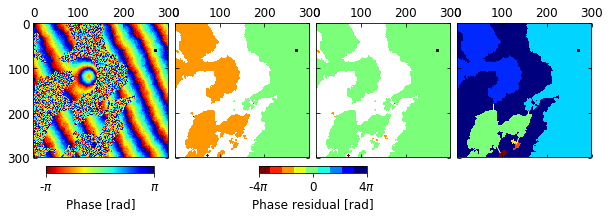

In [7]:
## Fig. 2 - bridging result

# read data
conncomp = readfile.read(cc_file)[0]
cc = connectComponent(conncomp=conncomp, metadata=atr)
cc.label(min_area=50, erosion_size=1)
cc.find_mst_bridge()

sim_unw = readfile.read(sim_unw_file)[0]; sim_unw -= sim_unw[ref_y, ref_x];# sim_unw[cc.conncomp==0] = np.nan
snf_unw = readfile.read(snf_unw_file)[0]; snf_unw -= snf_unw[ref_y, ref_x];# snf_unw[cc.conncomp==0] = np.nan
bdg_unw = readfile.read(bdg_unw_file)[0]; bdg_unw -= bdg_unw[ref_y, ref_x];# bdg_unw[cc.conncomp==0] = np.nan
sim_int = ut.wrap(sim_unw)
snf_err = sim_unw - snf_unw
bdg_err = sim_unw - bdg_unw
snf_err[cc.conncomp==0] = np.nan
bdg_err[cc.conncomp==0] = np.nan
Nmax = np.round(np.nanmax(np.abs(snf_err)) / np.pi).astype(int)
vlim = Nmax * np.pi

# plot
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=[10, 3], sharex=True, sharey=True)
im1 = axs[0].imshow(sim_int, cmap='jet_r', vmin=-np.pi,   vmax=np.pi)
# residual phase
cmap = pp.ColormapExt(cmap_name='jet_r', cmap_lut=2*Nmax+1).colormap
im2 = axs[1].imshow(snf_err, cmap=cmap, vmin=-1.*vlim, vmax=vlim)
im3 = axs[2].imshow(bdg_err, cmap=cmap, vmin=-1.*vlim, vmax=vlim)
im4 = cc.plot_bridge(axs[3], cmap='jet', radius=0)

# axis format
for ax in axs:
    ax.plot(ref_x, ref_y, 'ks', ms=2)
    ax.xaxis.tick_top()
    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
fig.subplots_adjust(wspace=0.05)
#axs[1,1].set_xlabel('Range [pix.]', fontsize=font_size)
#pp.set_shared_ylabel(axs.flatten(), 'Azimuth [pix.]', font_size=font_size, labelpad=-0.075)

## colorbar
cax1 = fig.add_axes([0.143, 0.12, 0.15, 0.03])
cbar1 = plt.colorbar(im1, cax=cax1, orientation='horizontal', ticks=[-np.pi, np.pi])
cbar1.ax.set_xticklabels([r'-$\pi$', r'$\pi$'])
cbar1.ax.tick_params(labelsize=font_size)
cbar1.set_label('Phase [rad]', fontsize=font_size)

cax2 = fig.add_axes([0.438, 0.12, 0.15, 0.03])
cbar2 = plt.colorbar(im2, cax=cax2, orientation='horizontal', ticks=[-1.*vlim, 0, vlim])
cbar2.ax.set_xticklabels([r'-{}$\pi$'.format(Nmax), '0', r'{}$\pi$'.format(Nmax)])
cbar2.ax.tick_params(labelsize=font_size)
cbar2.set_label('Phase residual [rad]', fontsize=font_size)

# save
out_file = os.path.join(os.getcwd(), 'sim_bridging.png')
#plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('saved to file', out_file)
plt.show()